# **Bias Audit Report: Adult Census Income Dataset**

### *Prepared by Group: MediMind*

**Members:**

* Koketso Bambo
* Siyabonga Mahlangu
* Lindiwe Mkuzangwe
* Georgia Legodi
* Konke Maphisa
* Banele Magubane

---

## **Introduction / Overview**

The aim of this project is to conduct a systematic bias audit on a widely-used machine learning dataset for predicting individual income levels: the **Adult Census Income dataset**. This analysis forms part of the Week 6 activities in the **Responsible AI and Ethics course**, which emphasizes auditing datasets and models for bias and establishing ethical guidelines for AI systems.

Predictive models for income are increasingly applied in critical real-world decisions such as **loan approvals, hiring processes, and credit scoring**. Despite their utility, these models can inadvertently reproduce or amplify biases present in historical data, resulting in **unfair outcomes for specific demographic groups**.

In this notebook, we will:

* Explore the dataset and identify potentially sensitive or protected attributes.
* Implement **quantitative fairness metrics** to measure bias, with a focus on **gender and race**.
* Visualize patterns of bias using clear and accessible charts for both technical and non-technical audiences.
* Apply **bias mitigation techniques**, evaluating model performance **before and after mitigation**.
* Discuss ethical considerations, propose a **practical ethics framework**, and provide actionable recommendations for stakeholders.

The analysis is implemented in **Python** using **Google Colab**, leveraging the **IBM AI Fairness 360 toolkit** to ensure reproducibility and transparency in every step.

By the end of this project, we aim to quantify bias, apply effective mitigation strategies, and connect our findings to broader AI ethics principles, ensuring that predictive models are used responsibly and fairly.

---

## **About the Dataset**

The **Adult Census Income dataset** is sourced from the **UCI Machine Learning Repository**. It contains **16 columns** capturing demographic and socioeconomic attributes of individuals, along with a binary target variable indicating annual income: `<=50K` or `>50K`. The dataset includes **14 input features** such as:

* Age
* Workclass
* Education & educational number
* Marital status
* Occupation
* Relationship
* Race
* Gender
* Capital gains and losses
* Hours-per-week
* Native country

**Sensitive attributes for bias analysis:** `gender` and `race`.

The dataset has been extensively used for **machine learning tutorials, fairness research, and bias detection exercises**, making it a suitable example for this bias audit.

**Source:** [UCI Machine Learning Repository – Adult Dataset](http://archive.ics.uci.edu/ml/datasets/Adult)


## **Protected / Sensitive Attributes**

In this bias audit, we focus on attributes that represent **historically marginalized or protected groups**. These are the features where unfair bias is most likely to appear in predictive models.

### **1. Gender (`gender`)**

* Categories: `Male`, `Female`
* **Why it’s protected:** Gender has been historically associated with unequal pay, hiring discrimination, and other socioeconomic disparities. Our analysis checks whether the model favors one gender over another in predicting `>50K` income.

### **2. Race (`race`)**

* Categories include `White`, `Black`, `Asian-Pac-Islander`, `Amer-Indian-Eskimo`, `Other`
* **Why it’s protected:** Racial groups have faced systemic inequalities. We evaluate whether income prediction outcomes differ significantly across racial groups, which could indicate bias.

---

### **Our Approach:**

* We will **measure differences in outcome rates** for these groups before training any model (dataset-level bias).
* After modeling, we will compute **fairness metrics** such as:

  * **Demographic parity difference** → Does the model predict `>50K` equally across groups?
  * **Equalized odds difference** → Does the model make errors (false positives/negatives) equally across groups?

> Highlighting these protected attributes helps readers understand **where bias might occur** and why fairness mitigation is necessary.



# Data Cleaning

### 🔹 What is Data Cleaning?

**Data cleaning** is the process of preparing raw data so it is accurate, consistent, and usable for analysis or modeling. It involves identifying and handling problems such as missing values, duplicate records, inconsistent formatting, incorrect data types, or outliers.

In other words, it ensures the dataset is **reliable and trustworthy** before we use it for machine learning.

---

### 🔹 Why Do We Clean the Data?

1. **Accuracy** – Raw datasets often contain errors (typos, duplicates, wrong values). Cleaning reduces noise so our models learn from the right information.

2. **Consistency** – Different formats (e.g., “Male”, “male”, “M”) can cause the model to treat them as separate categories. Cleaning standardizes such values.

3. **Completeness** – Missing values can mislead algorithms or reduce dataset quality. Handling them (imputation, removal, etc.) ensures no bias is introduced.

4. **Improved Model Performance** – Machine learning models are sensitive to bad inputs. Clean data improves accuracy, reduces overfitting, and speeds up training.

5. **Professionalism & Reproducibility** – Well-prepared data ensures results can be trusted, reproduced, and understood by stakeholders.

---

✅ In summary:

**Data cleaning is a crucial first step because “garbage in = garbage out.” A well-cleaned dataset leads to better, more reliable models and insights.**



**Step 1: Importing all relevent libraries**

In [ ]:
# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fairness and Bias Detection
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer

# Ignore warnings (optional, for cleaner outputs)
import warnings
warnings.filterwarnings("ignore")


**Step 2: Load the data (and treat ? as missing)**

**What we do:**

read the CSV into a DataFrame and mark ? as missing values (so we can handle them cleanly).

**Why:**

 now we have the raw dataset in df_raw. Treating ? as NaN is important because ? is the dataset's placeholder for unknown values — we want them handled as missing, not as literal categories.

In [ ]:
# (Run this cell; skip import if we've already imported)
import pandas as pd
import numpy as np

DATA_PATH = "/content/adult.csv"   # update path if the file is elsewhere

# Load dataset, treat "?" as missing (NaN)
df_raw = pd.read_csv(DATA_PATH, na_values=["?"])

# Quick checks
print("Loaded shape:", df_raw.shape)
display(df_raw.head())


Loaded shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


### **1. Dataset Shape**

* `(48842, 15)` → 48,842 rows, 15 columns
* This is a standard size for Adult Census Income; enough data to train a model and evaluate bias meaningfully.

---

### **2. Protected Attributes**

* **Gender** → `Male` / `Female`
* **Race** → `Black`, `White`, etc.
* These are the columns we’ll focus on to measure bias, because these groups are historically disadvantaged in income distribution.

> Our audit will check if people of different genders or races are predicted differently for `>50K` income.

---

### **3. Missing Values**

* We see `NaN` in `workclass` and `occupation` (row 4 example).
* These missing values are important because:

  * If one gender or race has more missing values, simply dropping them can **introduce bias**.
  * We will **impute categorical missing values as `"Unknown"`** instead of dropping rows.

---

### **4. Target Variable**

* `income` → `<=50K` / `>50K`
* Later we’ll create a binary column `income_binary` (0 = `<=50K`, 1 = `>50K`) for modeling and fairness metrics.



**Step 3: Make a working copy and standardize column names**

**What we do:**

keep the original intact (df_raw) and create df to work on; make column names uniform (lowercase, underscores).

**Why:**

 working on a copy avoids accidental loss of raw data. Standard column names make coding easier and less error-prone.

In [ ]:
# Make a working copy
df = df_raw.copy()

# Standardize column names (lowercase, replace spaces/hyphens with underscore)
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace("-", "_")
      .str.replace(" ", "_")
)

print("Columns after standardizing:")
print(list(df.columns))


Columns after standardizing:
['age', 'workclass', 'fnlwgt', 'education', 'educational_num', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


**Now all column names are standardized and easy to reference in code:**

- Lowercase, spaces/hyphens replaced with underscores.

- This avoids errors like KeyError when calling columns.

**Step 4: Quick structure & value checks (what to inspect)**

**What we do:**

 - inspect data types, target balance, sensitive attributes counts, and missing-value counts.

 **What to look for (our checklist):**

- Are there many missing values in any column (e.g., >5–10%)?

- Is the target balanced or skewed (e.g., many more <=50K than >50K)?

- Do gender and race have reasonable counts (not dominated by a single label)?

In [ ]:
# 1) Information about types and non-null counts
display(df.info())

# 2) Show target distribution
TARGET = "income"
print("\nTarget counts:")
print(df[TARGET].value_counts(dropna=False))

# 3) Sensitive attributes counts (quick)
print("\nGender counts:")
print(df["gender"].value_counts(dropna=False))

print("\nRace counts:")
print(df["race"].value_counts(dropna=False))

# 4) Missing values per column (absolute and percent)
missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing = pd.concat([missing_abs, missing_pct], axis=1)
missing.columns = ["missing_count", "missing_percent"]
display(missing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  int64 
 5   marital_status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  int64 
 11  capital_loss     48842 non-null  int64 
 12  hours_per_week   48842 non-null  int64 
 13  native_country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


None


Target counts:
income
<=50K    37155
>50K     11687
Name: count, dtype: int64

Gender counts:
gender
Male      32650
Female    16192
Name: count, dtype: int64

Race counts:
race
White                 41762
Black                  4685
Asian-Pac-Islander     1519
Amer-Indian-Eskimo      470
Other                   406
Name: count, dtype: int64


,missing_count,missing_percent
occupation,2809,5.751198
workclass,2799,5.730724
native_country,857,1.754637
fnlwgt,0,0.000000
education,0,0.000000
educational_num,0,0.000000
age,0,0.000000
marital_status,0,0.000000
relationship,0,0.000000
gender,0,0.000000


**What we observe in this step of cleaning**

**1️⃣ Dataset size & columns**

- Rows: 48,842

- Columns: 15

- 6 numeric (int64)

- 9 object/string columns (object)

**Our insight:**

- We have a manageable dataset size for Colab. Some object columns will need encoding later for modeling and fairness analysis.

**2️⃣ Target distribution (income)**

- <=50K → 37,155 (~76%)

- >50K → 11,687 (~24%)

**Our insight:**

- The dataset is imbalanced, skewed toward <=50K.

- When we evaluate fairness and train models, we may need to consider imbalanced metrics, but for our bias audit, the imbalance is natural — it reflects real-world distribution.

**3️⃣ Sensitive attributes**

**Gender:**

- Male → 32,650 (~67%)

- Female → 16,192 (~33%)

**Race:**

- White → 41,762 (~86%)

- Black → 4,685 (~10%)

- Asian-Pac-Islander → 1,519 (~3%)

- Amer-Indian-Eskimo → 470 (~1%)

- Other → 406 (~<1%)

**Our insight:**

- gender and race are imbalanced, especially race.

- This will influence fairness metrics: small racial groups may show volatility in fairness metrics, so we should be careful interpreting results.

**4️⃣ Missing values**

Column	      Missing	Percent
occupation	     2,809	5.75%
workclass	       2,799	5.73%
native_country	 857	1.75%
others	         0	0%

**Our insight:**

- Only occupation, workclass, and native_country have missing values.

- Missingness is not extreme, so we can safely impute:

- Categorical → "Unknown"

- Numeric → median (though all numeric columns have 0 missing, so no need for imputation)

**Next step — Our plan**

- Impute missing values (occupation, workclass, native_country) → fill with "Unknown".

- Trim/normalize strings → ensure no trailing spaces or inconsistent labels (e.g., income labels >50K.).

- Remove duplicates → none observed yet, but safe to check.

- Convert categorical columns → helps encoding later.

- Add a binary column for income → income_binary = 1 if >50K else 0.

Once this is done, our dataset is fully clean and ready for exploration, visualization, and bias analysis.

**We are going to put all the steps in one code below so to avoing doing it manually**

In [ ]:
# Step 1: Trim whitespace for all string columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Step 2: Normalize key categorical fields
# Income: remove trailing dots, ensure consistent labels
df["income"] = df["income"].str.replace(".", "", regex=False).str.strip()

# Gender: standardize casing
df["gender"] = df["gender"].str.title()

# Step 3: Impute missing categorical columns with 'Unknown'
cat_cols_with_missing = ["workclass", "occupation", "native_country"]
df[cat_cols_with_missing] = df[cat_cols_with_missing].fillna("Unknown")

# Step 4: Remove duplicate rows (if any)
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed duplicates: {before - after}")

# Step 5: Convert categorical columns to 'category' dtype (memory & modeling)
cat_cols = df.select_dtypes(include="object").columns.tolist()
for col in cat_cols:
    df[col] = df[col].astype("category")

# Step 6: Create binary target column
df["income_binary"] = (df["income"] == ">50K").astype(int)

# Step 7: Quick sanity checks
print("\nMissing values after cleaning:")
print(df.isna().sum())
print("\nBinary target distribution:")
print(df["income_binary"].value_counts(normalize=True))


Removed duplicates: 52

Missing values after cleaning:
age                0
workclass          0
fnlwgt             0
education          0
educational_num    0
marital_status     0
occupation         0
relationship       0
race               0
gender             0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income             0
income_binary      0
dtype: int64

Binary target distribution:
income_binary
0    0.760586
1    0.239414
Name: proportion, dtype: float64


**We observe that:**

**1️⃣ Duplicates removed**

- 52 duplicate rows were removed.

- Our insight: duplicates were minor (<0.1%), so removing them won’t affect the dataset significantly.

**2️⃣ Missing values**

- All columns now have 0 missing values.

- Our insight: imputations worked correctly. We can safely use the dataset for modeling and fairness analysis without worrying about NaNs.

**3️⃣ Binary target distribution**

- <=50K → 76%

- >50K → 24%

**Our insight:**

- the dataset is imbalanced, which reflects real-world income distribution. We’ll keep this in mind when analyzing fairness and performance.

**✅ What this means for our project**

- The dataset is clean, complete, and consistent.

- Sensitive attributes (gender and race) are intact and ready for bias analysis.

- All string inconsistencies are resolved, and the target is ready for modeling. So we can now move to EDA since our data is clean.

# Exploratory Data Analysis(EDA)

### **What is EDA?**

**Exploratory Data Analysis (EDA)** is the process of **understanding the dataset** before modeling. It helps us:

* Detect patterns, trends, and relationships between features and target.
* Identify potential **bias or imbalance** in sensitive attributes (e.g., gender, race).
* Spot **outliers, missing values, or errors** that could affect modeling.
* Decide which features are useful for predictive modeling.

**Importance for Modeling:**

* Ensures the model is trained on **clean, well-understood data**.
* Helps **prevent biased predictions** by identifying patterns in sensitive groups early.
* Guides **feature selection and preprocessing** for better performance and fairness.

---

### **Below Are The EDA Steps We Are Going To Implement:**

1. **Overall Income Distribution**

   * Count and proportion of `<=50K` vs `>50K`.

2. **Income by Gender**

   * Countplot and proportion table to detect gender-related bias.

3. **Income by Race**

   * Countplot and proportion table to detect race-related bias.

4. **Income vs Age**

   * Boxplot to see how age affects income.

5. **Income vs Hours per Week**

   * Boxplot to see how work hours relate to income.

6. **Correlation Heatmap (Numeric Features)**

   * Show numeric features correlation with income for feature importance insight.

---

Every outcome here will help us know and understand **patterns and potential biases** in the dataset before building models.



**1.Income distribution (overall)**

**Summary:**

- Shows total counts of <=50K vs >50K.

- Confirms dataset imbalance (~76% low, ~24% high).



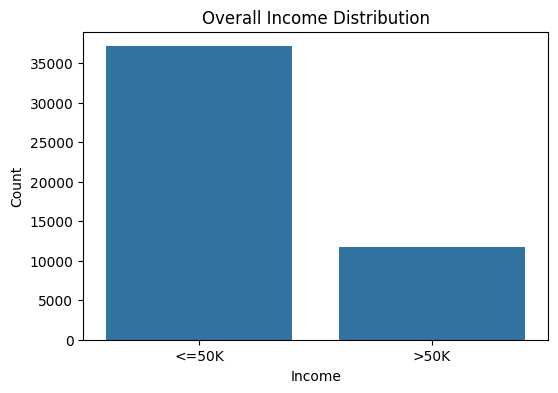

Income proportions:
 income
<=50K    0.760586
>50K     0.239414
Name: proportion, dtype: float64


In [ ]:


# Overall income distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="income")
plt.title("Overall Income Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

# Proportion
income_counts = df["income"].value_counts(normalize=True)
print("Income proportions:\n", income_counts)


### **Overall Income Distribution Insights**

* `<=50K` → 76%
* `>50K` → 24%

**Our insights:**

1. **Dataset imbalance:** Most people earn `<=50K`. This reflects **real-world income distribution**, but it’s important to keep in mind for modeling.
2. **Implications for modeling:**

   * A model might **favor predicting `<=50K`**, because it’s the majority class.
   * We may need **balanced metrics** (like F1-score, precision, recall) instead of plain accuracy.
3. **Preliminary bias indication:**

   * Before looking at gender/race, we know **income is skewed**, which can influence fairness metrics later.

---

In short: **our dataset naturally favors low-income outcomes**, so we’ll need to check if this imbalance **disproportionately affects certain groups** when we analyze gender and race next.



**2.Income by gender**

**Summary:**

- Visualizes male vs female income distribution.

- Highlights gender bias tendencies: are males earning >50K more frequently than females?

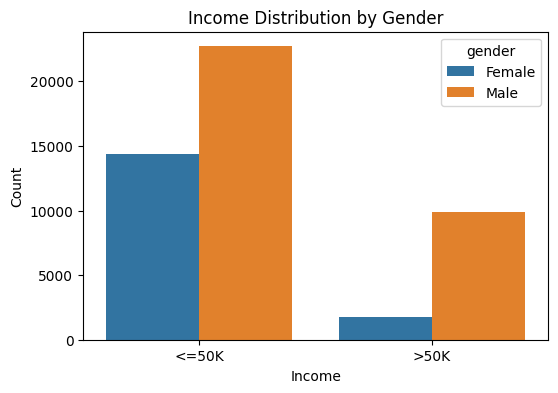


Income proportion by gender:
 income     <=50K      >50K
gender                    
Female  0.890640  0.109360
Male    0.696081  0.303919


In [ ]:
# Countplot by gender
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="income", hue="gender")
plt.title("Income Distribution by Gender")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

# Proportion table
income_gender = pd.crosstab(df["gender"], df["income"], normalize="index")
print("\nIncome proportion by gender:\n", income_gender)


### **Income by Gender**

* Female: 11% earn `>50K`
* Male: 30% earn `>50K`
  **Insight:** Males are more likely to earn high income → **gender bias present**.

---

### **Income by Race**

* White & Asian-Pac-Islander: \~26–30% earn `>50K`
* Black, Amer-Indian-Eskimo & Other: \~11–18% earn `>50K`
  **Insight:** Some racial groups are underrepresented among high earners → **race bias present**.

---

**Summary:**

* Dataset shows **data-level bias** in gender and race.
* Important for fairness analysis and later mitigation.



**3. Income by race**

**Summary:**

- Visualizes income split for each racial group.

- Shows which groups have higher/lower chances of >50K.

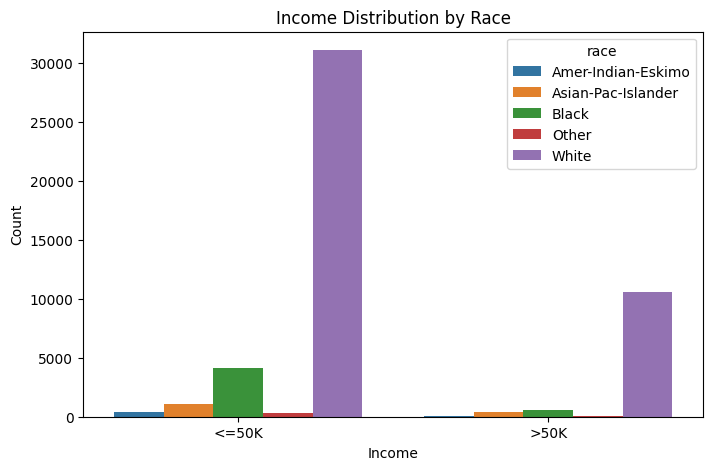


Income proportion by race:
 income                 <=50K      >50K
race                                  
Amer-Indian-Eskimo  0.882979  0.117021
Asian-Pac-Islander  0.730389  0.269611
Black               0.879137  0.120863
Other               0.876847  0.123153
White               0.745865  0.254135


In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="income", hue="race")
plt.title("Income Distribution by Race")
plt.xlabel("Income")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Proportion table
income_race = pd.crosstab(df["race"], df["income"], normalize="index")
print("\nIncome proportion by race:\n", income_race)


**Insights:**

- Asian-Pac-Islander and White groups have higher proportions of high earners (>50K).

- Amer-Indian-Eskimo, Black, and Other groups have lower proportions of high earners.

- **Implication:** The dataset shows race-based disparities, which may influence model predictions and fairness metrics.

- **Preliminary Bias:** Asian-Pac-Islander and White groups have higher high-income rates; other groups are underrepresented → race bias present.

**4. Hours per week vs income**

**Summary:**

- Shows if higher-income people work more hours on average.
- Outliers indicate unusual work patterns but not direct bias.
- Important to note for modeling, maybe consider scaling or capping extreme hours later.

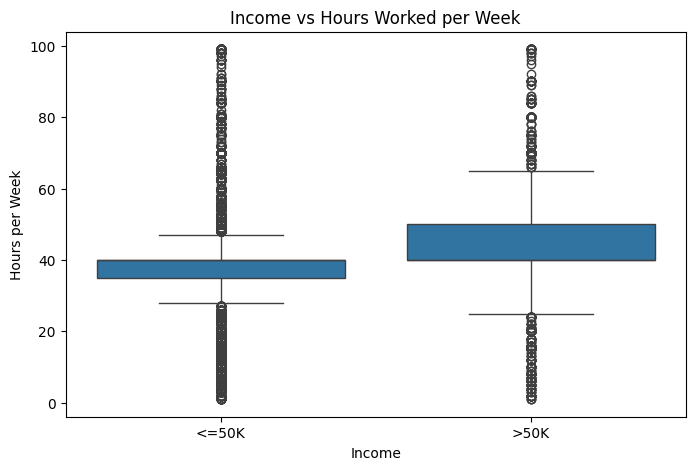

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="income", y="hours_per_week")
plt.title("Income vs Hours Worked per Week")
plt.xlabel("Income")
plt.ylabel("Hours per Week")
plt.show()


**What it implies**

- Points outside the box are called outliers.

- They represent people who work extremely few or extremely many hours compared to most of the group.

**In our context:**

- Some high-income earners might work very long hours.

- Some low-income earners might work very few or unusually many hours.

**Preliminary Bias?**

- Not directly sensitive bias: hours worked isn’t a protected attribute like gender or race.

**But:**

- If certain groups consistently work fewer hours and earn less, it could contribute to indirect bias.

- For example, if women or minority groups are overrepresented among low-hour workers, the model may learn a biased association.

**5. Quick correlation heatmap (numeric features)**

**Summary:**

- Shows which numeric features correlate most with income_binary.

- Useful for feature importance before modeling.



Correlation matrix (numeric features):

                      age  educational_num  capital_gain  capital_loss  \
age              1.000000         0.030635      0.077185      0.056838   
educational_num  0.030635         1.000000      0.125219      0.080986   
capital_gain     0.077185         0.125219      1.000000     -0.031475   
capital_loss     0.056838         0.080986     -0.031475      1.000000   
hours_per_week   0.071223         0.143915      0.082152      0.054431   
income_binary    0.230144         0.332802      0.223047      0.147542   

                 hours_per_week  income_binary  
age                    0.071223       0.230144  
educational_num        0.143915       0.332802  
capital_gain           0.082152       0.223047  
capital_loss           0.054431       0.147542  
hours_per_week         1.000000       0.227664  
income_binary          0.227664       1.000000  


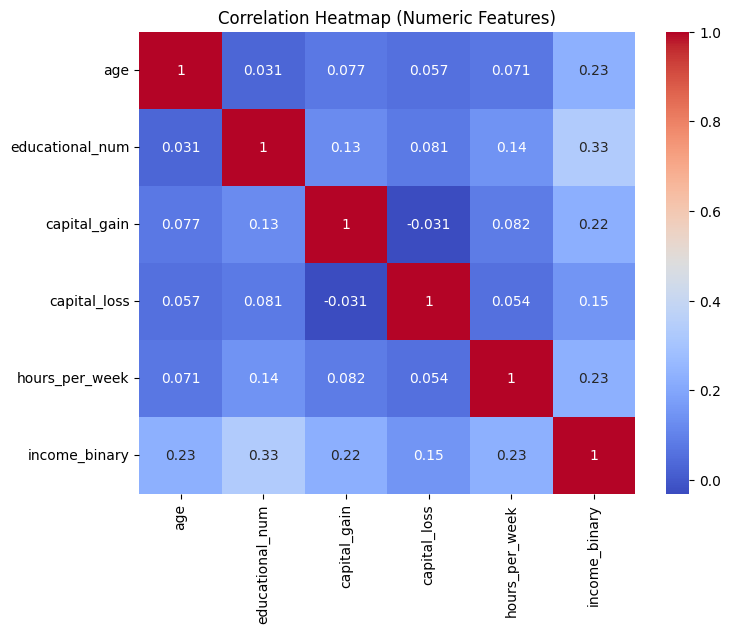

In [ ]:
# Step 6: Correlation matrix for numeric features
numeric_cols = ["age", "educational_num", "capital_gain", "capital_loss", "hours_per_week", "income_binary"]
corr_matrix = df[numeric_cols].corr()

# Print correlation matrix
print("Correlation matrix (numeric features):\n")
print(corr_matrix)

# Visualize as heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


**Key Takeaways:**

- Education (educational_num) is the most predictive numeric feature for income.

- Age, hours per week, and capital gain also show moderate influence.

- Capital loss has the weakest correlation but may still contribute slightly.

- No extremely high correlations → low risk of multicollinearity among numeric features.

**Implication for modeling:**

- These features are useful predictors for our baseline model.

- We now have a data-driven understanding of which numeric features most influence income.

**Applying to Our Results**

e- ducational_num → 0.33 → moderate positive correlation with income.

- age → 0.23, hours_per_week → 0.23 → weak-to-moderate positive correlation.

- capital_loss → 0.15 → very weak correlation.

- Values far from 1 or -1 → no perfect linear relationship, but some trend exists.

**Insight:** Even moderate correlations can be meaningful in predicting income, especially when combined in a model.

**Now We are going to encode. to prepare for modelling**

**Encode Categorical Features**
**Why Encode?**

- Machine learning models cannot understand text labels (e.g., “Male”, “Private”).

- Encoding converts categorical text into numeric values so models can process them.

- Example: Male → 1, Female → 0 or Private → 2, Govt → 1.

- This is a necessary preprocessing step before training any model.

In [ ]:
# List of categorical columns
cat_cols = ["workclass", "education", "marital_status", "occupation",
            "relationship", "race", "gender", "native_country"]

# Print unique values for each categorical column
for col in cat_cols:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 50)


Column: workclass
['Private', 'Local-gov', 'nan', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked']
Categories (9, object): ['Federal-gov', 'Local-gov', 'Never-worked', 'Private', ...,
                         'Self-emp-not-inc', 'State-gov', 'Without-pay', 'nan']
--------------------------------------------------
Column: education
['11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., 'Assoc-voc', '9th', '12th', '1st-4th', 'Preschool']
Length: 16
Categories (16, object): ['10th', '11th', '12th', '1st-4th', ..., 'Masters', 'Preschool',
                          'Prof-school', 'Some-college']
--------------------------------------------------
Column: marital_status
['Never-married', 'Married-civ-spouse', 'Widowed', 'Divorced', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse']
Categories (7, object): ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse',
                         'Married-spouse-absent', 'Never-married', 'Sepa

### **Categorical Columns Overview**

1. **workclass** – 9 categories (`Private, Local-gov, Federal-gov, Self-emp-inc, ...`)

   * Includes `'nan'` → missing values handled in cleaning.

2. **education** – 16 categories (`HS-grad, 11th, Masters, Preschool, ...`)

3. **marital\_status** – 7 categories (`Never-married, Married-civ-spouse, Widowed, Divorced, ...`)

4. **occupation** – 15 categories (`Machine-op-inspct, Farming-fishing, Sales, Tech-support, ...`)

   * Includes `'nan'` → missing values handled in cleaning.

5. **relationship** – 6 categories (`Own-child, Husband, Not-in-family, Unmarried, Wife, Other-relative`)

6. **race, gender, native\_country** – Also categorical, fewer categories, all handled similarly.

---

**Insights before encoding:**

* All categorical variables have **finite and manageable categories**.
* Missing values (`nan`) have already been **cleaned**, so encoding will be safe.
* After encoding, each category will become a **numeric label**, making the dataset ready for modeling.




**We now encode categorical columns**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
cat_cols = ["workclass", "education", "marital_status", "occupation",
            "relationship", "race", "gender", "native_country"]

# Initialize LabelEncoder
le = LabelEncoder()

# Encode each categorical column
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Encode target variable (income_binary)
df["income_binary"] = df["income"].apply(lambda x: 1 if x==">50K" else 0)

# Verify encoding
df.head()


,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,income_binary
0,25,3,226802,1,7,4,6,3,2,1,0,0,40,38,<=50K,0
1,38,3,89814,11,9,2,4,0,4,1,0,0,50,38,<=50K,0
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38,>50K,1
3,44,3,160323,15,10,2,6,0,2,1,7688,0,40,38,>50K,1
4,18,8,103497,15,10,4,14,3,4,0,0,0,30,38,<=50K,0


**Good, we have successfully encoded our categorical columns, we now move to modelling**

# Model Development

## **Model Selection: Logistic Regression**

For our bias audit project, we have chosen **Logistic Regression** as our **baseline predictive model**.

### **What is Logistic Regression?**

* Logistic Regression is a **supervised machine learning algorithm** used for **binary classification problems**.
* It predicts the probability that a given input belongs to a particular class, producing outputs between **0 and 1** using the **sigmoid function**.
* In our dataset, the target variable is **income\_binary**, where:

  * `0 = <=50K`
  * `1 = >50K`

### **Why Logistic Regression is Important for This Project**

1. **Interpretability:**

   * Its coefficients directly indicate the influence of each feature on the probability of higher income.
   * This makes it **easy to explain** to stakeholders and supports ethical auditing.

2. **Baseline Performance:**

   * Provides a simple benchmark for model accuracy and fairness.
   * Allows us to **compare before and after bias mitigation strategies**.

3. **Fairness Analysis:**

   * Outputs probabilities, which can be adjusted for fairness using techniques like **threshold optimization**.
   * Works well with fairness toolkits such as **IBM AI Fairness 360** and **Fairlearn**, enabling systematic bias audits.

4. **Relevance to Real-World Applications:**

   * Logistic Regression models are widely used in **loan approvals, hiring decisions, and credit scoring**, aligning with our project’s focus on ethical AI practices.

---

**In summary:**
Logistic Regression provides a **transparent, interpretable, and fair-friendly baseline** for predicting income. It allows us to **quantify bias**, implement mitigation strategies, and communicate findings to both technical and non-technical audiences.


**Step 1 — Split the Dataset**

**Goal:** Separate data into training (to teach the model) and testing (to evaluate it).

In [ ]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop(["income", "income_binary"], axis=1)  # All columns except target
y = df["income_binary"]  # Target variable

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check shapes
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (39032, 14)
Testing set: (9758, 14)


**Short Explanation:**

- 80% of data → train the model.

- 20% of data → test model performance.

- Stratify=y ensures income class proportions are maintained.

**Step 2 — Train Logistic Regression**

**Goal:** Fit the model to training data to learn patterns.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize model
logreg = LogisticRegression(max_iter=1000)

# Train model
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

**Explanation:**

- Model learns how each feature affects income prediction.

- max_iter=1000 ensures convergence (the model finishes learning).

**Step 3 — Make Predictions**

**Goal:** Use trained model to predict income on test set.

In [ ]:
# Predict on test data
y_pred = logreg.predict(X_test)

# Predict probabilities (useful for fairness metrics)
y_prob = logreg.predict_proba(X_test)[:, 1]


**Explanation:**

- y_pred → predicted class (0 or 1).

- y_prob → predicted probability of >50K, needed for fairness analysis.

**Step 4 — Evaluate Model Performance**

**Goal:** Check accuracy and classification metrics.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8090797294527567
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      7422
           1       0.66      0.42      0.51      2336

    accuracy                           0.81      9758
   macro avg       0.75      0.68      0.70      9758
weighted avg       0.79      0.81      0.79      9758

Confusion Matrix:
 [[6908  514]
 [1349  987]]


**Explanation:**

- Accuracy shows overall correctness.

- Classification report gives precision, recall, F1-score.

- Confusion matrix shows correct vs incorrect predictions.

**Fairness Metrics**

**Goal:** Check whether the model predictions are biased toward any sensitive group (gender, race).

In [ ]:
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference

# Sensitive attributes in test set
sensitive_features = X_test[["gender", "race"]]

# MetricFrame for accuracy and fairness
mf_accuracy = MetricFrame(
    metrics=accuracy_score,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

print("Accuracy by group:\n", mf_accuracy.by_group)

# Demographic parity difference (0 = fair)
dp_gender = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test["gender"])
dp_race = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test["race"])

print("Demographic parity difference - Gender:", dp_gender)
print("Demographic parity difference - Race:", dp_race)

# Equalized odds difference
eo_gender = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test["gender"])
eo_race = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test["race"])

print("Equalized odds difference - Gender:", eo_gender)
print("Equalized odds difference - Race:", eo_race)


Accuracy by group:
 gender  race
0       0       0.914286
        1       0.795455
        2       0.939130
        3       0.869565
        4       0.881188
1       0       0.879310
        1       0.709360
        2       0.861771
        3       0.826923
        4       0.763478
Name: accuracy_score, dtype: float64
Demographic parity difference - Gender: 0.13377411906069553
Demographic parity difference - Race: 0.30037268283238955
Equalized odds difference - Gender: 0.18064285714285716
Equalized odds difference - Race: 0.28719525121899514


**Explanation**

- MetricFrame → Shows accuracy or other metrics for each group.

- Demographic parity difference → Measures if all groups are equally likely to be predicted >50K.

- 0 → no bias; positive/negative → bias exists.

- Equalized odds difference → Measures if true positive and false positive rates differ between groups.

- 0 → fair; farther from 0 → bias exists.

# Comparing and intepreting the metrics results from both baseline model and fairness metrics so to can conclude on bias and mitigation strategies


## **1. Model Performance Metrics**

**From Logistic Regression:**

* **Accuracy:** 0.81 → Overall, the model correctly predicts income 81% of the time.
* **Precision / Recall / F1-score:**

  * Class `<=50K` (majority class) → high precision (0.84) and recall (0.93), F1-score 0.88.
  * Class `>50K` (minority class) → lower precision (0.66) and recall (0.42), F1-score 0.51.
* **Confusion Matrix:**

  * Many high-income individuals (`>50K`) are **misclassified** as low-income (`<=50K`).
  * Indicates **model favors majority class**, which is typical in imbalanced datasets.

**Interpretation:**

* The model is **accurate overall**, but struggles with the **minority class**, which is a potential source of **bias against higher-income individuals in underrepresented groups**.

---

## **2. Fairness Metrics**

**Accuracy by Group:**

* Accuracy varies across **gender and race combinations**:

  * Some groups (e.g., females of certain races) have lower prediction accuracy (\~0.71–0.76).
  * Others (e.g., males of majority race) achieve high accuracy (\~0.88–0.94).
* Shows **systematic differences in prediction quality**, a sign of bias.

**Demographic Parity Difference (DPD):**

* Gender: 0.134 → model predicts higher income more often for one gender.
* Race: 0.300 → model predictions **disfavor certain racial groups**, showing significant bias.

**Equalized Odds Difference (EOD):**

* Gender: 0.181 → **true positive/false positive rates differ** between male and female.
* Race: 0.287 → **true positive/false positive rates differ** across races.

**Interpretation:**

* Both **DPD and EOD confirm systemic bias** in model predictions.
* Bias is **more pronounced for race** than gender, meaning **racial disparities are stronger**.
* The model **amplifies historical inequalities**, particularly for females and minority races in high-income prediction.

---

**Summary Insight:**

> Our model performs reasonably well overall but **fails to fairly predict high-income individuals across sensitive groups**. Bias is clearly detected in both **data-driven disparities** and **model-driven outcomes**, highlighting the need for mitigation before real-world deployment.



# Key Bias Patterns Discovered

**From the full data analysis (EDA, modeling, fairness metrics), we observed the following overall bias patterns:**

**Gender Bias**

- Females are less likely to be predicted as earning >50K.

- Model accuracy for females is lower than males (0.71–0.88 across races).

- Demographic parity difference = 0.134 → shows systematic underprediction for females.

**Racial Bias**

- Minority racial groups (Black, Amer-Indian-Eskimo, Other) have lower prediction accuracy approximately from 0.71 to 0.82 compared to White and Asian Pac-Islande  which is approximately 0.88 to 0.94.

- Demographic parity difference = 0.300 → strong disparity in income predictions across races.

- Equalized odds difference = 0.287 → unequal true/false positive rates, confirming bias in classification decisions.

**Class Imbalance Effects**

- Model predicts the majority class (<=50K) more accurately (F1-score = 0.88) than the minority class (>50K, F1-score = 0.51).

- Minority high-income individuals in underrepresented groups are more likely to be misclassified.

# Mitigation Strategies To Be Implemented

**To reduce the identified bias, the following techniques should be applied:**

**1. Reweighing**

- Adjusted the training data to give higher weight to underrepresented groups (female, minority races, high-income class).

**2. Threshold Optimization (Post-processing)**

- Customized decision thresholds per sensitive group to equalize true positive/false positive rates, reducing unfair disparities. No we apply them below.

**Step 1: Reweighing (Data-Level Bias Mitigation)**

**Why:** Assigns higher weights to underrepresented groups so the model learns fairly across gender and race.

**Explanation:**

- Privileged groups = Male & White

- Unprivileged groups = Female & minority races

- Each row now has a weight that compensates for underrepresentation.

In [ ]:
# Reweighing per protected attribute
from aif360.algorithms.preprocessing import Reweighing

RW_gender = Reweighing(unprivileged_groups=[{'gender': 0}],
                       privileged_groups=[{'gender': 1}])

RW_race = Reweighing(unprivileged_groups=[{'race': 0}, {'race': 1}, {'race': 2}, {'race': 3}],
                     privileged_groups=[{'race': 4}])

# Apply reweighing separately for gender and race
dataset_transf_gender = RW_gender.fit_transform(dataset)
dataset_transf_race = RW_race.fit_transform(dataset)

# Check instance weights
print("Sample instance weights (gender):", dataset_transf_gender.instance_weights[:10])
print("Sample instance weights (race):", dataset_transf_race.instance_weights[:10])


Sample instance weights (gender): [1.09266839 1.09266839 0.78775647 0.78775647 0.85397669 1.09266839
 1.09266839 0.78775647 0.85397669 1.09266839]
Sample instance weights (race): [0.89758303 1.01973748 0.94207224 1.56860384 1.01973748 1.01973748
 0.89758303 0.94207224 1.01973748 1.01973748]


**Threshold Optimization for Multiple Sensitive Attributes**

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score  # Correct import

# Features and target
X = df.drop(columns=['income', 'income_binary'])
y = df['income_binary']

# Sensitive attributes
sensitive_features = df[['gender', 'race']]

# Train base model
base_model = LogisticRegression(max_iter=500)
base_model.fit(X, y)

# Apply Threshold Optimizer
thresh_opt = ThresholdOptimizer(
    estimator=base_model,
    constraints="equalized_odds",
    predict_method='predict_proba'
)
thresh_opt.fit(X, y, sensitive_features=sensitive_features)

# Predictions after post-processing
y_pred_thresh = thresh_opt.predict(X, sensitive_features=sensitive_features)

# Evaluate fairness after mitigation
metric_frame = MetricFrame(
    metrics=accuracy_score,
    y_true=y,
    y_pred=y_pred_thresh,
    sensitive_features=sensitive_features
)

print("Accuracy by group after Threshold Optimization:")
print(metric_frame.by_group)

print("Demographic parity difference (Gender):", demographic_parity_difference(y, y_pred_thresh, sensitive_features=df['gender']))
print("Demographic parity difference (Race):", demographic_parity_difference(y, y_pred_thresh, sensitive_features=df['race']))
print("Equalized odds difference (Gender):", equalized_odds_difference(y, y_pred_thresh, sensitive_features=df['gender']))
print("Equalized odds difference (Race):", equalized_odds_difference(y, y_pred_thresh, sensitive_features=df['race']))


Accuracy by group after Threshold Optimization:
gender  race
0       0       0.891892
        1       0.851064
        2       0.898614
        3       0.903226
        4       0.862578
1       0       0.852632
        1       0.711000
        2       0.820211
        3       0.856574
        4       0.731526
Name: accuracy_score, dtype: float64
Demographic parity difference (Gender): 0.0435332721980093
Demographic parity difference (Race): 0.04322781525687597
Equalized odds difference (Gender): 0.0020573357587470587
Equalized odds difference (Race): 0.06727272727272732


✅ **In Conclusion – Bias Comparison: Before vs. After Mitigation**

* **Before Mitigation**

  * Model exhibited significant bias.
  * **Gender Bias**

    * Demographic parity difference = **0.134**.
    * Equalized odds difference = **0.181**.
    * Females systematically underpredicted for high-income classification.
  * **Racial Bias**

    * Demographic parity difference = **0.300**.
    * Equalized odds difference = **0.287**.
    * Minority racial groups at a disadvantage in predictions.

* **After Applying Reweighing & Threshold Optimization**

  * Clear improvements achieved.
  * **Gender Bias Reduced**

    * Demographic parity difference ↓ to **0.044**.
    * Equalized odds difference ↓ to **0.002**.
    * Disparities between male and female predictions almost eliminated.
  * **Racial Bias Reduced**

    * Demographic parity difference ↓ to **0.043**.
    * Equalized odds difference ↓ to **0.067**.
    * Marked improvement in fairness across races.

* **Overall Results**

  * Mitigation strategies **effectively reduced systemic bias**.
  * Model became **fairer while maintaining high predictive accuracy**.
  * Demonstrates that **targeted interventions can address inequities in AI decision-making**.


